In [2]:
import cv2
import numpy as np
import imutils
import matplotlib.pyplot as plt
import easyocr
import re

In [3]:
def order_points(pts):
	rect = np.zeros((4, 2), dtype = "float32")
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]

	return rect

In [4]:
def four_point_transform(image, pts):
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	return warped

# CARREGAR IMAGEM

In [284]:
image = cv2.imread('testeback.jpeg')
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height = 500)
detail = cv2.detailEnhance(image,sigma_s = 20, sigma_r = 0.15)
gray = cv2.cvtColor(detail,cv2.COLOR_BGR2GRAY) # GRAYSCALE IMAGE
blur = cv2.GaussianBlur(gray,(5,5),0)
# edge detect
edge_image = cv2.Canny(blur,75,200)
# morphological transform
kernel = np.ones((5,5),np.uint8)
dilate = cv2.dilate(edge_image,kernel,iterations=1)
closing = cv2.morphologyEx(dilate,cv2.MORPH_CLOSE,kernel)
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# gray = cv2.GaussianBlur(gray, (5, 5), 0)
# edged = cv2.Canny(gray, 75, 200)
cnts = cv2.findContours(closing.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
for c in cnts:
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
	if len(approx) == 4:
		screenCnt = approx
		break
warped = four_point_transform(orig, screenCnt.reshape(4, 2) * ratio)
aligned = imutils.resize(warped, width=1100).copy()
aligned = cv2.detailEnhance(aligned, sigma_s=20, sigma_r=0.20)
cv2.imwrite('resultado.jpg', aligned)

True

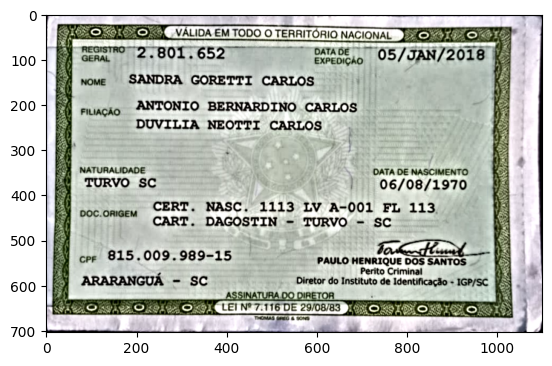

In [285]:
plt.imshow(aligned)
plt.show()

# FUNÇOES OCR

In [286]:
def distancia_entre_pontos(ponto1, ponto2):
    ponto1 = np.array(ponto1)
    ponto2 = np.array(ponto2)
    return np.linalg.norm(ponto2 - ponto1)

def ocr(img_ocr):
    reader = easyocr.Reader(["pt"], gpu=True)
    result = reader.readtext(img_ocr)
    return result

def roi(img_ocr, result, ref_x, ref_y, trust_score=0.8):
    distancia_min = float("inf")
    bbox_mais_proximo = None
    texto_roi = None
    for t in result:
        bbox, text, score = t
        altura = bbox[3][1] - bbox[0][1]
        if score > trust_score and altura > 25:
            distancia = distancia_entre_pontos([ref_x,ref_y], bbox[0])
            if distancia < distancia_min:
                distancia_min = distancia
                bbox_mais_proximo = bbox
                texto_roi = text
    top_left,top_right,bottom_right = bbox_mais_proximo[0],bbox_mais_proximo[1],bbox_mais_proximo[2]
    w = int(np.linalg.norm(np.array(top_left) - np.array(top_right)))
    h = int(np.linalg.norm(np.array(top_right) - np.array(bottom_right))) 
    img_recortada = img_ocr[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w]

    return img_recortada, top_left, w, h, texto_roi

# RODANDO OCR

In [287]:
resultados = ocr(aligned)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


# NOME COMPLETO

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


SANDRA  GORETTI CARLOS


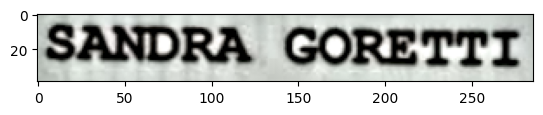

In [288]:
def valida_nome(imagem, top_left, w, h, texto):
    # Divide a string pelos espaços em branco
    partes = texto.strip().split()
    # Conta o número de palavras na string
    quantidade_nomes = len(partes)
    # Verifica se tem mais de um nome
    if quantidade_nomes > 2:
        return texto #teoricamente pegou o nome completo
    elif quantidade_nomes == 2:
        nova_roi = imagem[top_left[1]-10:top_left[1]+h+10, top_left[0]:top_left[0]+2*w]
    else:
        nova_roi = imagem[top_left[1]-10:top_left[1]+h+10, top_left[0]:top_left[0]+5*w]
    reader = easyocr.Reader(["pt"], gpu=True)
    resultado_nome = reader.readtext(nova_roi)
    nome_completo = ' '.join([nome for _, nome, confianca in resultado_nome if confianca > 0.3])
    return nome_completo

roi_nome, tp_nome, largura_nome, altura_nome, nome = roi(aligned, resultados, 130, 162, 0.1)
novo_nome = valida_nome(aligned, tp_nome, largura_nome, altura_nome, nome)
print(novo_nome)
plt.imshow(roi_nome)
plt.show()

# RG

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


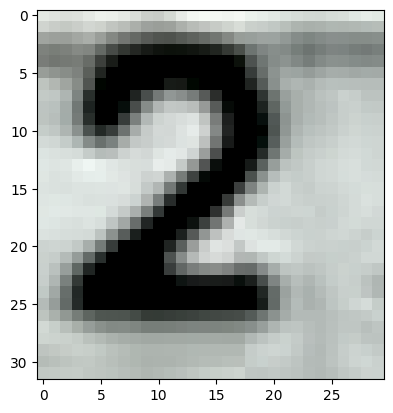

2. 801 . 652


In [289]:
def valida_cpf(imagem, top_left, w, h, n_cpf):
    tamanho = len(''.join(char for char in n_cpf if char.isdigit()))
    if tamanho == 9:
        return n_cpf #teoricamente pegou o cpf completo
    else:
        nova_roi = imagem[top_left[1]-10:top_left[1]+h+10, top_left[0]:top_left[0]+280]
        reader = easyocr.Reader(["pt"], gpu=True)
        resultado_cpf = reader.readtext(nova_roi)
        cpf_completo = '.'.join([digito for _, digito, confianca in resultado_cpf if confianca > 0.3])
        #cpf_completo = cpf_completo[:14]
        return cpf_completo #nova roi para rodar ocr novamente no cpf

roi_rg, tp_rg, largura_rg, altura_rg, rg = roi(aligned, resultados, 191, 74, 0.1)    
novo_rg = valida_cpf(aligned, tp_rg, largura_rg, altura_rg, rg)
plt.imshow(roi_rg)
plt.show()
print(novo_rg)

# CPF

815.009. 989-15


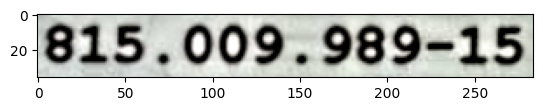

In [290]:

def valida_cpf(imagem, top_left, w, h, n_cpf):
    tamanho = len(''.join(char for char in n_cpf if char.isdigit()))
    if tamanho == 11:
        return n_cpf #teoricamente pegou o cpf completo
    else:
        nova_roi = imagem[top_left[1]-10:top_left[1]+h+10, top_left[0]:top_left[0]+280]
        reader = easyocr.Reader(["pt"], gpu=True)
        resultado_cpf = reader.readtext(nova_roi)
        cpf_completo = '.'.join([digito for _, digito, confianca in resultado_cpf if confianca > 0.3])
        #cpf_completo = cpf_completo[:14]
        return cpf_completo #nova roi para rodar ocr novamente no cpf
    
roi_cpf, tp_cpf, largura_cpf, altura_cpf, cpf = roi(aligned, resultados, 121, 529, 0.1)    
cpf_completo = valida_cpf(aligned, tp_cpf, largura_cpf, altura_cpf, cpf)
print(cpf_completo)
plt.imshow(roi_cpf)
plt.show()

# DATA DE NASCIMENTO

06/08/1970


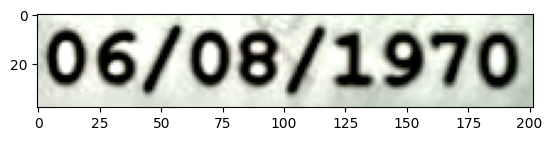

In [291]:
roi_data, tp_data, largura_data, altura_data, data = roi(aligned, resultados, 718, 365, 0.4) #teoricamente pega o cpf
print(data) # pode pegar só o primeiro, ou os dois primeiros. Fazer uma validação
plt.imshow(roi_data)
plt.show()

# NATURALIDADE

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


TURVO


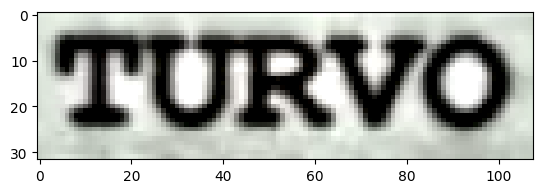

In [292]:
def valida_nome(imagem, top_left, w, h, texto):
    # Divide a string pelos espaços em branco
    partes = texto.strip().split()
    # Conta o número de palavras na string
    quantidade_nomes = len(partes)
    # Verifica se tem mais de um nome
    if quantidade_nomes > 2:
        return texto #teoricamente pegou o nome completo
    elif quantidade_nomes == 2:
        nova_roi = imagem[top_left[1]-10:top_left[1]+h+10, top_left[0]:top_left[0]+2*w]
    else:
        nova_roi = imagem[top_left[1]-10:top_left[1]+h+10, top_left[0]:top_left[0]+5*w]
    reader = easyocr.Reader(["pt"], gpu=True)
    resultado_nome = reader.readtext(nova_roi)
    nome_completo = ' '.join([nome for _, nome, confianca in resultado_nome if confianca > 0.2])
    return nome_completo
roi_registro, tp_registro, largura_registro, altura_registro, registro = roi(aligned, resultados, 82, 365, 0.3) #teoricamente pega o cpf
novo_nome = valida_nome(aligned, tp_registro, largura_registro, altura_registro, registro)

print(registro) # pode pegar só o primeiro, ou os dois primeiros. Fazer uma validação
plt.imshow(roi_registro)
plt.show()

# FOTO DO DOCUMENTO

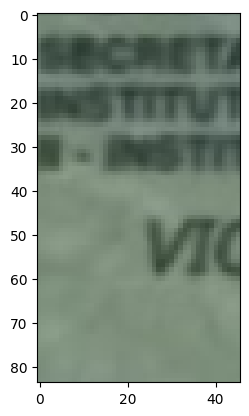

In [52]:
tp_foto = tp_nome.copy()
tp_foto[1] = tp_nome[1]+2*int(altura_nome)-20
foto = aligned[67:151, 145:191]
plt.imshow(cv2.cvtColor(foto, cv2.COLOR_BGR2RGB))
plt.show()